### Cross-Validation in Lasso Regression - Manual Implementation Task

In [128]:
# Libraries
import numpy as np
import pyreadr as rr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split

**1. Data Preparation**

Load the March Supplement of the U.S. Current Population Survey, year 2015. (wage2015_subsample_inference.Rdata)

In [117]:
rdata_read = rr.read_r("../../data/wage2015_subsample_inference.Rdata")
data = rdata_read[ 'data' ]

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5150 entries, 10 to 32643
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   wage    5150 non-null   float64 
 1   lwage   5150 non-null   float64 
 2   sex     5150 non-null   float64 
 3   shs     5150 non-null   float64 
 4   hsg     5150 non-null   float64 
 5   scl     5150 non-null   float64 
 6   clg     5150 non-null   float64 
 7   ad      5150 non-null   float64 
 8   mw      5150 non-null   float64 
 9   so      5150 non-null   float64 
 10  we      5150 non-null   float64 
 11  ne      5150 non-null   float64 
 12  exp1    5150 non-null   float64 
 13  exp2    5150 non-null   float64 
 14  exp3    5150 non-null   float64 
 15  exp4    5150 non-null   float64 
 16  occ     5150 non-null   category
 17  occ2    5150 non-null   category
 18  ind     5150 non-null   category
 19  ind2    5150 non-null   category
dtypes: category(4), float64(16)
memory usage: 736.3+ KB


We get the parameters vector (X) and the endogenous variable (y) from flexible model

In [119]:
# We choose the parameters from flexible model (includes interactions)
flex = 'lwage ~ sex + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'
flex_results_0 = smf.ols(flex, data=data)

In [120]:
# Get exogenous variables from flexible model
X = flex_results_0.exog

# Set endogenous variable
y = data["lwage"]

In [121]:
# Separate the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [122]:
# Se estandariza la data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

**2. Define a Range of Alpha (Lambda in our equation) Values**

We create a list or array of alpha values to iterate over. These will be the different regularization parameters we test. We started testing from 0.1 to 0.5 and found that the MSE in cross-validation was reducing when the alpha value was incrementing. Therefore, we tried with higher values.

In [142]:
alphas = [(45 + i * 5) for i in range(5)]

**3. Partition the Dataset for k-Fold Cross-Validation**

We divide the dataset into 5 subsets (or folds). Since we are working with a regression task (predicting the log of wage), we use the K-Fold cross-validator from sklearn. We ensure the data is shuffled by adding 'shuffle=True' and set a random state for a reproducible output. 

Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [143]:
kf = KFold(n_splits=5, shuffle=True, random_state=24)

**4. Lasso Regression Implementation**

Implement a function to fit a Lasso Regression model given a training dataset and an alpha value. The function should return the model's coefficients and intercept.

In [138]:
def lasso_regression(X_train, y_train, alpha, iterations=100, learning_rate=0.01):
    """
    Fits a Lasso Regression model

    Args:
        X_train: Training features
        y_train: Target values
        alpha: Regularization parameter (L1 penalty)
        iterations: Number of iterations for gradient descent (default: 100)
        learning_rate: Learning rate for gradient descent (default: 0.01)

    Returns:
        W: Model coefficients (weights)
        b: Model intercept (bias)
    """
    m, n = X_train.shape
    W = np.zeros(n)
    b = 0

    for _ in range(iterations):
        Y_pred = X_train.dot(W) + b
        dW = np.zeros(n)
        for j in range(n):
            if W[j] > 0:
                dW[j] = (-2 * X_train[:, j].dot(y_train - Y_pred) + alpha) / m
            else:
                dW[j] = (-2 * X_train[:, j].dot(y_train - Y_pred) - alpha) / m
        db = -2 * np.sum(y_train - Y_pred) / m
        W -= learning_rate * dW
        b -= learning_rate * db

    return W, b

**5. Cross-Validation Loop**

We immplement a for loop to fit the lasso regression.

**6. Selection of Optimal Alpha**

Also, we find the best value of alpha that reduces the average MSE for each fold.

Alpha=45.0, Average MSE: 0.41942
Alpha=50.0, Average MSE: 0.41920
Alpha=55.0, Average MSE: 0.41912
Alpha=60.0, Average MSE: 0.41906
Alpha=65.0, Average MSE: 0.41907
Best Alpha: 60.0, Minimum Average MSE: 0.41906


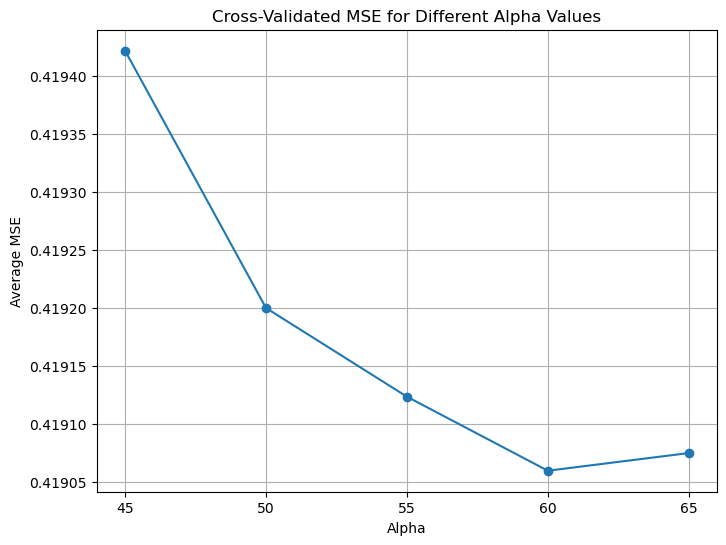

In [144]:
avg_mse_values = []
best_alpha = None
min_avg_mse = float('inf')

for alpha in alphas:
    mse_list = []  # Initialize an empty list to keep track of the MSE for each fold.
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train Lasso regression model with the current alpha
        W, b = lasso_regression(X_train_fold, y_train_fold, alpha)
        y_pred_val = X_val_fold.dot(W) + b

        # Calculate MSE for this fold
        mse_fold = np.mean((y_val_fold - y_pred_val) ** 2)
        mse_list.append(mse_fold)

    # Calculate average MSE across all folds
    avg_mse = np.mean(mse_list)
    avg_mse_values.append(avg_mse)
    print(f"Alpha={alpha:.1f}, Average MSE: {avg_mse:.5f}")

    # Update the best alpha and minimum average MSE
    if avg_mse < min_avg_mse:
        min_avg_mse = avg_mse
        best_alpha = alpha

print(f"Best Alpha: {best_alpha:.1f}, Minimum Average MSE: {min_avg_mse:.5f}")

# Plotting the cross-validated MSE for each alpha value
plt.figure(figsize=(8, 6))
plt.plot(alphas, avg_mse_values, marker='o', linestyle='-')
plt.title('Cross-Validated MSE for Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Average MSE')
plt.xticks(alphas)
plt.grid(True)
plt.show()

**7. Model Training and Evaluation**

In [145]:
W, b = lasso_regression(X_train, y_train, best_alpha)
y_pred = X_test.dot(W) + b

In [146]:
lasso_corr = pearsonr(y_test, y_pred)[0]
lasso_mae = mean_absolute_error(y_test, y_pred)

print(f"Correlación: {lasso_corr:.4f}")
print(f"MAE: {lasso_mae:.4f}")

Correlación: 0.5041
MAE: 0.4756


**8. Report Results**